In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
import os

# Choosing STRING edge confidence thresholds
The purpose of this notebook is to choose three cut-offs for including edges from STRING in an updated version of Monarch KG.

download STRING v12 pysical links detailed
https://stringdb-downloads.org/download/protein.links.full.v12.0/9606.protein.links.full.v12.0.txt.gz

I want only experimental data and not transfered experimental data. The scores reported in that file are originall floating point numbers 0.000-1.000 that have been multiplied by 1000 (presumably for storage purposes). I should threshold based on that experimental score.


In [5]:
string_file = '../Resources/9606.protein.links.full.v12.0.txt'
string_df = pd.read_csv(string_file, sep=' ')
print(string_df.head())
print('OG human STRING size',string_df.shape)
    

               protein1              protein2  neighborhood  \
0  9606.ENSP00000000233  9606.ENSP00000356607             0   
1  9606.ENSP00000000233  9606.ENSP00000427567             0   
2  9606.ENSP00000000233  9606.ENSP00000253413             0   
3  9606.ENSP00000000233  9606.ENSP00000493357             0   
4  9606.ENSP00000000233  9606.ENSP00000324127             0   

   neighborhood_transferred  fusion  cooccurence  homology  coexpression  \
0                         0       0            0         0             0   
1                         0       0            0         0             0   
2                         0       0            0         0            49   
3                         0       0            0         0            56   
4                         0       0            0         0             0   

   coexpression_transferred  experiments  experiments_transferred  database  \
0                        45            0                      134         0   
1     

In [6]:
# keep only rows with experimental != 0
string_df = string_df[string_df['experiments'] != 0]
print('Human string experimental only',string_df.shape)

Human string experimental only (1136680, 16)


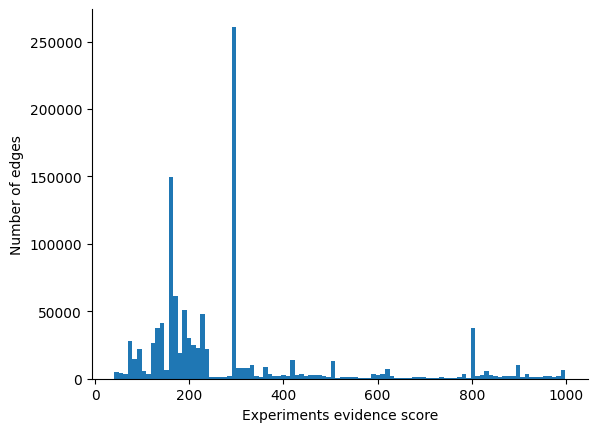

In [7]:
# plot the distribution of the experiments scores
fig, ax = plt.subplots()

ax.hist(string_df['experiments'], bins=100)
# label the axes
ax.set_xlabel('Experiments evidence score')
ax.set_ylabel('Number of edges')
# remove the top and right spines from plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Percentage of edges with > 0.85 confidence: 0.036173769222648415
Percentage of edges with > 0.30 confidence: 0.21128373860717176
Percentage of edges with > 0.15 confidence: 0.8282718091283386
Threshold for top 20% of edges: 314.0
Threshold for top 40% of edges: 292.0
Threshold for top 60% of edges: 190.0
Number of edges with > 314.0 confidence: 228956 0.2014252032234226
Number of edges with > 292.0 confidence: 501084 0.4408311925959813
Number of edges with > 190.0 confidence: 682640 0.60055600520815


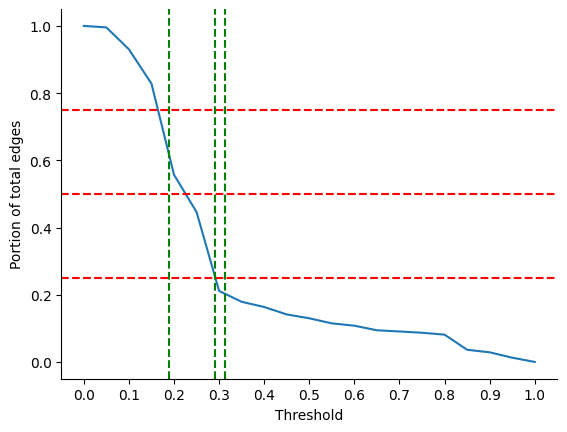

In [8]:
# make an arc like curce of threshold vs total edges included
# thresholds every 0.05 to 1.00
thresholds = [i/100 for i in range(0,101,5)]
xs = []
ys = []
for thresh in thresholds:
    string_df_thresh = string_df[string_df['experiments'] >= (thresh * 1000)]
    xs.append(thresh)
    ys.append(string_df_thresh.shape[0] / string_df.shape[0])

fig, ax = plt.subplots()
ax.plot(xs, ys)
ax.set_xlabel('Threshold')
ax.set_ylabel('Portion of total edges')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# label x ticks using 0.1 increments
ax.set_xticks([i/10 for i in range(0,11)])
# add h lines at .75, .5 and .25
ax.axhline(y=0.75, color='r', linestyle='--')
ax.axhline(y=0.5, color='r', linestyle='--')
ax.axhline(y=0.25, color='r', linestyle='--')

# what % of edges have > 0.85, 0.30, and 0.15 respectively
print('Percentage of edges with > 0.85 confidence:', string_df[string_df['experiments'] >= 850].shape[0] / string_df.shape[0])
print('Percentage of edges with > 0.30 confidence:', string_df[string_df['experiments'] >= 300].shape[0] / string_df.shape[0])
print('Percentage of edges with > 0.15 confidence:', string_df[string_df['experiments'] >= 150].shape[0] / string_df.shape[0])

# what is the thresholf for the top 20, 40 and 60 % of edges?
print('Threshold for top 20% of edges:', string_df['experiments'].quantile(0.8))
print('Threshold for top 40% of edges:', string_df['experiments'].quantile(0.6))
print('Threshold for top 60% of edges:', string_df['experiments'].quantile(0.4))

# plot v lines on the graph for the thresholds string_df['experiments'].quantile(0.8), string_df['experiments'].quantile(0.6), string_df['experiments'].quantile(0.4)
ax.axvline(x=string_df['experiments'].quantile(0.8)/1000, color='g', linestyle='--')
ax.axvline(x=string_df['experiments'].quantile(0.6)/1000, color='g', linestyle='--')
ax.axvline(x=string_df['experiments'].quantile(0.4)/1000, color='g', linestyle='--')

# how many edges are there for each of these thresholds? 314.0 292.0 190.0, also print the % of total edges
print('Number of edges with > 314.0 confidence:', string_df[string_df['experiments'] >= 314].shape[0], string_df[string_df['experiments'] >= 314].shape[0] / string_df.shape[0])
print('Number of edges with > 292.0 confidence:', string_df[string_df['experiments'] >= 292].shape[0], string_df[string_df['experiments'] >= 292].shape[0] / string_df.shape[0])
print('Number of edges with > 190.0 confidence:', string_df[string_df['experiments'] >= 190].shape[0], string_df[string_df['experiments'] >= 190].shape[0] / string_df.shape[0])



plt.show()

Based on the threshold vs portion of total edges plot I am going to choose the thresholds of 0.85, 0.30, and 0.15. These values correspond with inflection points in the graph and include the top 0.04, 0.21 and 0.83 portion of edges. My understanding of under this scoring metric, .3 does not necessarily mean bad, just that there is drastically more potential for confidence too.

# portion vs inflection based
Instead what if I choose thresholds based on the % of calls, what is the threshold for the top 20,40 and 60%

In [9]:
# what is the thresholf for the top 20, 40 and 60 % of edges?
print('Threshold for top 20% of edges:', string_df['experiments'].quantile(0.8))
print('Threshold for top 40% of edges:', string_df['experiments'].quantile(0.6))
print('Threshold for top 60% of edges:', string_df['experiments'].quantile(0.4))

Threshold for top 20% of edges: 314.0
Threshold for top 40% of edges: 292.0
Threshold for top 60% of edges: 190.0


# Create thresholded edge lists
These convertions were made using SynGO https://www.syngoportal.org/convert, remember to cite this paper: https://www.sciencedirect.com/science/article/pii/S0896627319304271?via%3Dihub


In [10]:
# read in Resources/idmap.xlsx
idmap_file = '../Resources/idmap.xlsx'
idmap_df = pd.read_excel(idmap_file)
print(idmap_df.head())
# create a query to HGNC symbol dictionary
query_to_symbol = dict(zip(idmap_df['query'], idmap_df['symbol']))

             query  entrezgene                               name   symbol  \
0  ENSP00000263100         1.0             alpha-1-B glycoprotein     A1BG   
1  ENSP00000378868     29974.0     APOBEC1 complementation factor     A1CF   
2  ENSP00000323929         2.0              alpha-2-macroglobulin      A2M   
3  ENSP00000299698    144568.0       alpha-2-macroglobulin like 1    A2ML1   
4  ENSP00000475261    127550.0  alpha 1,3-galactosyltransferase 2  A3GALT2   

                               alias   taxid        HGNC  
0            A1B, ABG, GAB, HYST2477  9606.0      HGNC:5  
1  ACF, ACF64, ACF65, APOBEC1CF, ASP  9606.0  HGNC:24086  
2       A2MD, CPAMD5, FWP007, S863-7  9606.0      HGNC:7  
3                  CPAMD9, OMS, p170  9606.0  HGNC:23336  
4            A3GALT2P, IGB3S, IGBS3S  9606.0  HGNC:30005  


In [11]:
# remove 9606. prefix from protein1 and protein2 columns
string_df['protein1'] = string_df['protein1'].apply(lambda x: x.split('.')[1])
string_df['protein2'] = string_df['protein2'].apply(lambda x: x.split('.')[1])

# map protein1 and protein2 to HGNC symbols
string_df['protein1'] = string_df['protein1'].map(query_to_symbol)
string_df['protein2'] = string_df['protein2'].map(query_to_symbol)


# Create new Monarch versions

In [40]:
def replace_monarchs_hgnc(m_path,string_df):
    monarch_df = pd.read_csv(m_path, sep='\t',header=None)
    monarch_df.columns = ['subject','predicate','object']
    print(monarch_df.shape)
    # get the HGNC nodes in monarch
    monarch_nodes = set([x for x in list(monarch_df['subject'].unique()) + list(monarch_df['object'].unique()) if 'HGNC:' in x])    
    # get the string nodes
    string_nodes = set(list(string_df['protein1'].unique()) + list(string_df['protein2'].unique()))
    # get the nodes in monarch but not in string
    monarch_not_in_string = monarch_nodes - string_nodes
    # remove rows from monarch_df where subject or object is in monarch_not_in_string
    monarch_df = monarch_df[~monarch_df['subject'].isin(monarch_not_in_string)]
    monarch_df = monarch_df[~monarch_df['object'].isin(monarch_not_in_string)]
    # remove rows from monarch where subject and object are HGNC: nodes
    monarch_df['is_g2g'] = ['HGNC:' in row['subject'] and 'HGNC:' in row['object'] for i,row in monarch_df.iterrows()]
    monarch_df = monarch_df[~monarch_df['is_g2g']]
    # add all string edges to monarch_df, with a predicate of 'biolink:interacts_with'
    string_df['predicate'] = 'biolink:interacts_with'
    string_df = string_df[['protein1','predicate','protein2']]
    string_df.columns = ['subject','predicate','object']
    # drop the is_g2g column in monarch
    monarch_df = monarch_df.drop(columns=['is_g2g'])
    monarch_df = pd.concat([monarch_df, string_df])
    print(monarch_df.shape)

    # double check work
    # get all HGNC nodes in monarch
    monarch_nodes = set([x for x in list(monarch_df['subject'].unique()) + list(monarch_df['object'].unique()) if 'HGNC:' in str(x)])
    # assert they are all in string
    assert monarch_nodes.issubset(string_nodes)

    print('Dropping duplicates')
    monarch_df = monarch_df.drop_duplicates()
    print(monarch_df.shape)

    return monarch_df



def make_random_split_of_edges(monarch_df,output_dir,seed=42):
    duplicate_rows = monarch_df.duplicated()
    print('Pre: Number of duplicate rows:', duplicate_rows.sum())
    # if output_dir does not exist, create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # if out dir does not end with a /, add one
    if not output_dir.endswith('/'):
        output_dir += '/'
    # split the df edges randomly
    np.random.seed(seed)
    # create a random 80/10/10 split of the edges
    train = monarch_df.sample(frac=0.8, random_state=seed)
    test = monarch_df.drop(train.index).sample(frac=0.5, random_state=seed)
    val = monarch_df.drop(train.index).drop(test.index)
    # save the train, test, and val sets to the output_dir
    train.to_csv(output_dir + 'train.txt', sep='\t', index=False, header=False)
    test.to_csv(output_dir + 'test.txt', sep='\t', index=False, header=False)
    val.to_csv(output_dir + 'valid.txt', sep='\t', index=False, header=False)

    # assert there is no overlap between the sets
    all_df = pd.concat([train, test, val])
    duplicate_rows = all_df.duplicated()
    print('Number of duplicate rows:', duplicate_rows.sum())
    # assert duplicate_rows.shape == (0,)
    print(train.shape, val.shape, test.shape)

# establish the percentile thresholds
top_25 = string_df['experiments'].quantile(0.79) # note that if you use < 78 there are a bunch of ties and the number of edges is not 25%, more like 49% of the edges. This really results in the top 21%
top_50 = string_df['experiments'].quantile(0.5)


# subset the string_df to only include edges with confidence above the thresholds
top_25_df = string_df[string_df['experiments'] >= top_25]
top_50_df = string_df[string_df['experiments'] >= top_50]
top_100_df = string_df

print('Top 25%:', top_25_df.shape[0], top_25_df.shape[0] / string_df.shape[0])
print('Top 50%:', top_50_df.shape[0], top_50_df.shape[0] / string_df.shape[0])
print('Top 100%:', top_100_df.shape[0], top_100_df.shape[0] / top_100_df.shape[0])

# replace the HGNC: nodes in monarch with the HGNC: nodes in string
top_25_mdf = replace_monarchs_hgnc('../Monarch_KG/monarch-kg_triples.2023-12-16.tsv',top_25_df)
make_random_split_of_edges(top_25_mdf, '../ELs_for_Rotate/Monarch_STRING_t25/', 42)

top_50_mdf = replace_monarchs_hgnc('../Monarch_KG/monarch-kg_triples.2023-12-16.tsv',top_50_df)
make_random_split_of_edges(top_50_mdf, '../ELs_for_Rotate/Monarch_STRING_t50/', 42)

top_100_mdf = replace_monarchs_hgnc('../Monarch_KG/monarch-kg_triples.2023-12-16.tsv',top_100_df)
make_random_split_of_edges(top_100_mdf, '../ELs_for_Rotate/Monarch_STRING_t100/', 42)




Top 25%: 239080 0.21033184361473767
Top 50%: 574546 0.5054597600028152
Top 100%: 1136680 1.0
(11412471, 3)


/tmp/ipykernel_5996/2110929112.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  string_df['predicate'] = 'biolink:interacts_with'


(8937433, 3)
Dropping duplicates
(7126686, 3)
Pre: Number of duplicate rows: 0
Number of duplicate rows: 0
(5701349, 3) (691363, 3) (693742, 3)
(11412471, 3)


/tmp/ipykernel_5996/2110929112.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  string_df['predicate'] = 'biolink:interacts_with'


(9272899, 3)
Dropping duplicates
(7456244, 3)
Pre: Number of duplicate rows: 0
Number of duplicate rows: 0
(5964995, 3) (694216, 3) (699730, 3)
(11412471, 3)
(9835033, 3)
Dropping duplicates
(8006448, 3)
Pre: Number of duplicate rows: 0
Number of duplicate rows: 0
(6405158, 3) (698459, 3) (709724, 3)
